# Exploring the Knowledge Graph

### Definition of functions to access, query and plot the knowledge graph/subgraphs

In [29]:
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def getGraphDatabaseConnectionConfiguration():
    host = config.dbURL
    port = config.dbPort
    user = config.dbUser
    password = config.dbPassword

    driver = connectToDB(host, port, user, password)

    return driver

def connectToDB(host = "localhost", port= 7687, user="neo4j", password = "password"):
    driver = Graph(host=host, port = port, user = user, password = password)

    return driver

def simplePlotGraph(graph):
    G=nx.Graph()
    for rel in graph["relationships"]:
        snode = rel.start_node
        enode = rel.end_node
        if "name" in snode and "name" in enode:
            G.add_edge(snode["name"],enode["name"], label=rel.type)
    plt.figure(3,figsize=(25,25)) 
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos,node_size=260,font_size=16)
    plt.axis('off')
    plt.show()
    
def getCursorData(cursor, header):
    df = pd.DataFrame(cursor)
    return df

### Definition of Cypher queries to extract information from the graph

In [46]:
dbstats_queries = {"num_nodes":'''MATCH (n) RETURN count(n);''',
           "num_relationships":'''MATCH ()-->() RETURN count(*);''',
           "type_nodes":'''MATCH (n) WHERE rand() <= 0.1
                           RETURN
                           DISTINCT labels(n),
                           count(*) AS SampleSize,avg(size(keys(n))) as Avg_PropertyCount, 
                           min(size(keys(n))) as Min_PropertyCount,
                           max(size(keys(n))) as Max_PropertyCount,
                           avg(size( (n)-[]-() ) ) as Avg_RelationshipCount,
                           min(size( (n)-[]-() ) ) as Min_RelationshipCount,
                           max(size( (n)-[]-() ) ) as Max_RelationshipCount;''',
           "schema":'''CALL db.schema();'''}
project_queries = {"existing_projects": '''MATCH (n:Project) RETURN n.name AS Name, n.acronym AS acronym, n.responsible AS Responsible''',
                  "subjects": '''MATCH (p:Project)-[r:HAS_ENROLLED]->(s:Subject) RETURN p.name AS Project, s.id AS Id, s.external_id AS External'''}
analytical_samples = {"proteins": '''MATCH (a:Analytical_sample{id:"IDENTIFIER"})-[r:HAS_QUANTIFIED_PROTEIN]->(p:Protein) 
                                    RETURN a.id AS Analytical_sampleId, p.id AS ProteinId, p.name AS Name, 
                                    p.synonyms AS Synonyms, r.value AS Intensity LIMIT 25''',
                     "peptides": '''MATCH (a:Analytical_sample{id:"IDENTIFIER"})-[r:HAS_QUANTIFIED_PEPTIDE]->(p:Peptide) 
                                    RETURN a.id AS Analytical_sampleId, p.id AS PeptideId, p.name AS Name, 
                                    r.value AS Intensity LIMIT 25''',
                     "ptm": '''MATCH (a:Analytical_sample{id:"IDENTIFIER"})-[r:HAS_QUANTIFIED_MODIFIED_PROTEIN]->(p:Modified_protein) 
                             RETURN a.id AS Analytical_sampleId, p.id AS PTMId, 
                             p.protein AS Protein, p.position AS position , p.residue as Residue LIMIT 25'''}
mentions_queries = {"disease":'''MATCH (d:Disease{id:"DISEASE"})-[r:MENTIONED_IN_PUBLICATION]->(pubmed:Publication) RETURN d.id AS Id, d.name AS Name, pubmed.id AS PUBMEDID LIMIT 25'''}
variant_queries = {"subject":'''MATCH (a:Analytical_sample)-[r:CONTAINS_MUTATION]->(s:Somatic_mutation) RETURN a.id AS AnalyticalSampleId, s.id AS SomaticMutationId  LIMIT 25'''}

## Connect to the graph

In [3]:
graph = connectToDB( user="neo4j", password = "bioinfo1112")

### Access some of the graph statistics

In [4]:
getCursorData(cursor = graph.run(dbstats_queries["num_nodes"]).data(), header = ["Number of Nodes"])

,count(n)
0,16087786


In [5]:
getCursorData(cursor = graph.run(dbstats_queries["num_relationships"]).data(), header = ["Number of Relationships"])

,count(*)
0,112522103


In [6]:
getCursorData(cursor = graph.run(dbstats_queries["type_nodes"]).data(), header = ["Types"])

,Avg_PropertyCount,Avg_RelationshipCount,Max_PropertyCount,Max_RelationshipCount,Min_PropertyCount,Min_RelationshipCount,SampleSize,labels(n)
0,5.000000,4718.735593,5,467068,5,0,590,[Tissue]
1,5.000000,2499.542652,5,1343478,5,1,973,[Disease]
2,5.000000,9.370787,5,1260,5,1,2848,[Biological_process]
3,5.000000,7.217626,5,503,5,1,1112,[Molecular_function]
4,5.000000,442.065534,5,30864,5,1,412,[Cellular_component]
5,5.000000,1222.507692,5,235423,5,1,195,[Modification]
6,5.000000,9.009961,5,14911,5,0,44173,[Clinical_variable]
7,5.000000,7.532557,5,1268,5,1,1459,[Phenotype]
8,5.000000,1.720755,5,21,5,0,265,[Experiment]
9,3.000000,300310.000000,3,300310,3,300310,1,[Chromosome]


### Plot the data model

/Users/plh450/CKG_env_updated/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


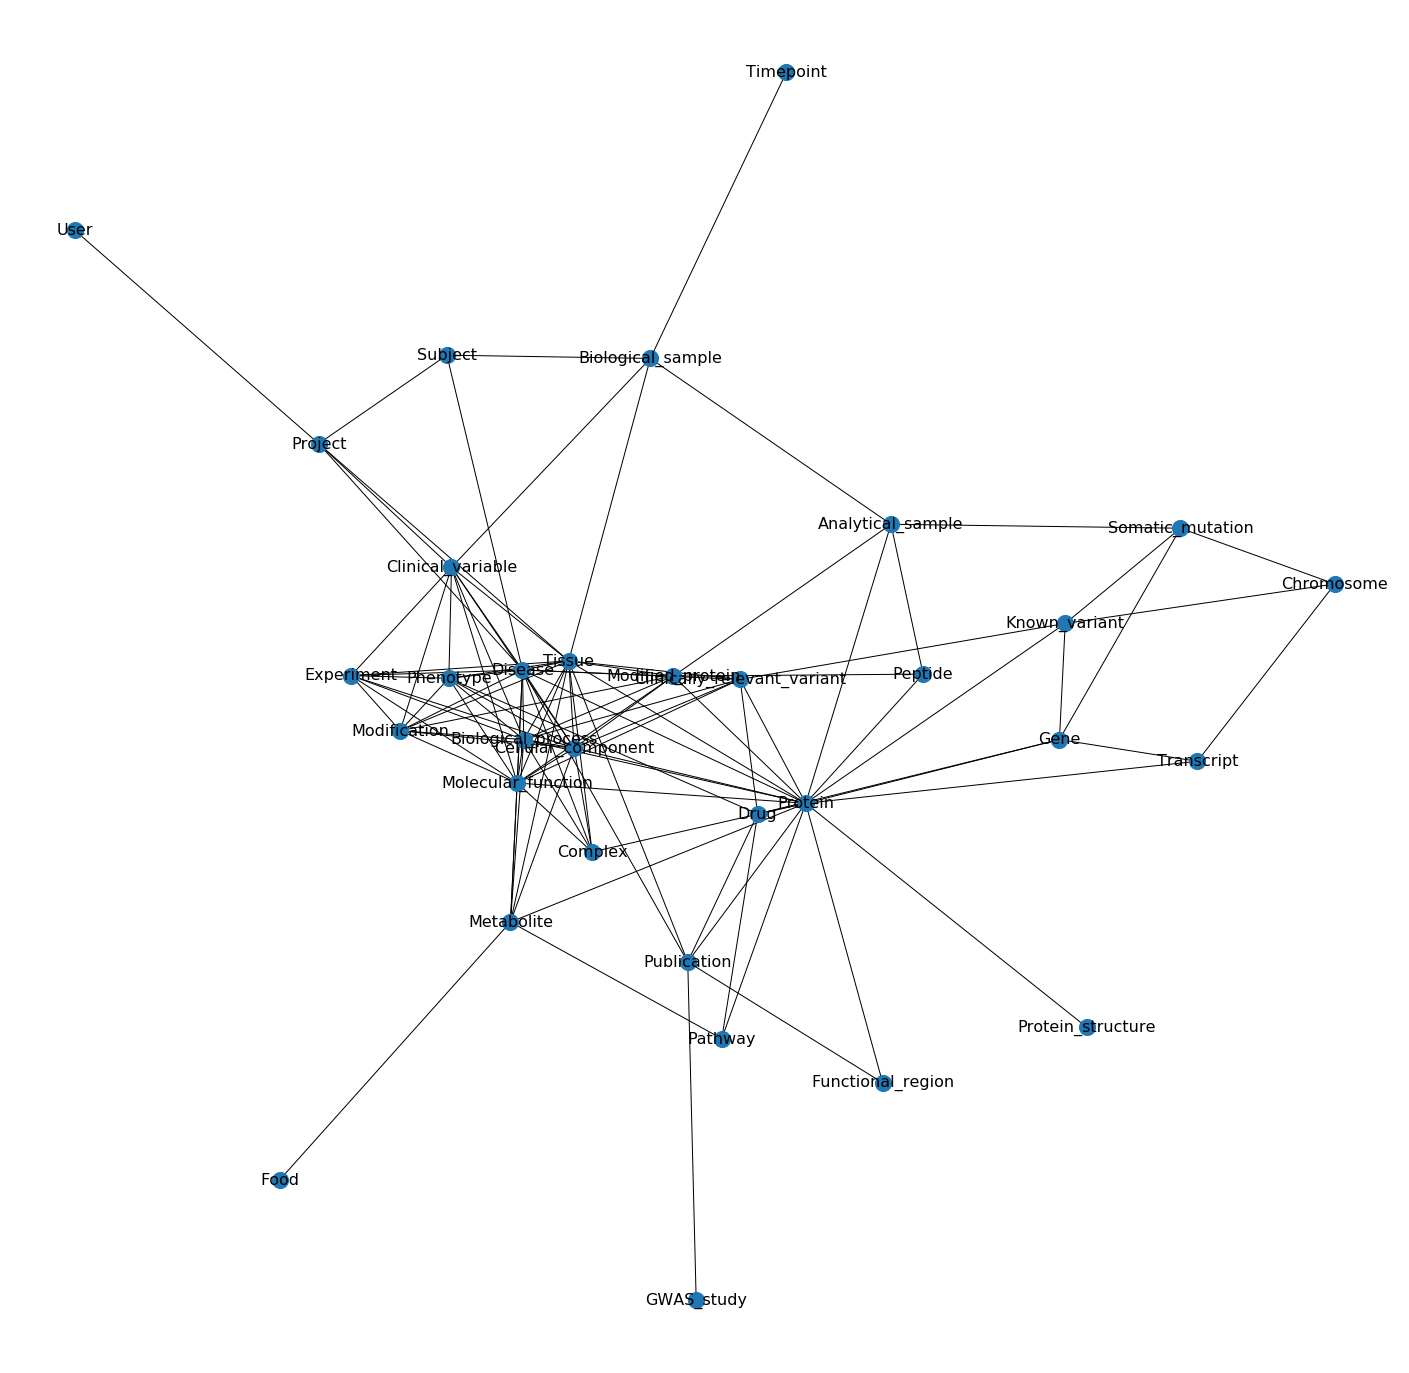

In [28]:
subgraph = graph.run(dbstats_queries["schema"]).data()[0]
simplePlotGraph(subgraph)

### Projects already in the database

In [30]:
getCursorData(cursor = graph.run(project_queries["existing_projects"]).data(), header = ["Types"])

,Name,Responsible,acronym
0,Ovarian cancer study,Fabian Coscia,HGSOC
1,CaseStudyUrachal,Sophia Doll,CSU
2,Weight loss study,Nicolai J. Wewer Albrechtsen|Philipp E. Geyer,WLS
3,Bariatric surgery,Nicolai J. Wewer Albrechtsen|Philipp E. Geyer,BSS
4,Non-alcoholic Fatty Liver Disease,Lili Niu,NAFLD


In [31]:
getCursorData(cursor = graph.run(project_queries["subjects"]).data(), header = ["Types"]).set_index(["Project", "Id"]).sort_values(by="External")

,,External
Project,Id,
Bariatric surgery,S79,04MP
Weight loss study,S126,1
Non-alcoholic Fatty Liver Disease,S1,1
Ovarian cancer study,S202,1
Non-alcoholic Fatty Liver Disease,S10,10
Ovarian cancer study,S195,10
Weight loss study,S134,10
Bariatric surgery,S80,10EA
Non-alcoholic Fatty Liver Disease,S11,11


In [35]:
getCursorData(cursor = graph.run(analytical_samples["proteins"].replace("IDENTIFIER", "AS30")).data(), header = ["Types"]).set_index(["Analytical_sampleId", "ProteinId"]).sort_values(by="Name")

Intensity        Name  \
Analytical_sampleId ProteinId                          
AS30                U5LKM6     31.379272       APOL1   
                    U5LKP5     31.379272       APOL1   
                    U5LIJ1     31.379272       APOL1   
                    U5LIH6     31.379272       APOL1   
                    X6RLJ0     28.748136        C1QA   
                    Q9BY43     27.962567      CHMP4A   
                    Q9NQ79     29.821757      CRTAC1   
                    Q96CG0     24.342724         ENG   
                    Q9BWU5     34.490049         HBB   
                    Q9ULI3     23.469508        HEG1   
                    V9HWP2     24.781068  HEL-S-125m   
                    V9HWG1     21.952906  HEL-S-134P   
                    V9HWP0     31.867654   HEL-S-92n   
                    V9HWH1     22.514799       HEL57   
                    Q9Y4L1     25.531957       HYOU1   
                    U5XHE0     26.738279      LILRA6   
                    U5XHC8     26.738279      LILRB3   
                    U5XJY5     26.738279      LILRB3   
                    U5XKH1     26.738279      LILRB3   
                    X5D7M1     27.157419        NRP2   
                    Q96S96     22.428619       PEBP4   
                    X6RJP6     22.712446      TAGLN2   
                    Q9HCC1     25.553533        None   
                    Q9UL86     26.995287        None   
                    Q9UII7     23.105970        None   

                                                                        Synonyms  
Analytical_sampleId ProteinId                                                     
AS30                U5LKM6                                 [U5LKM6_HUMAN, APOL1]  
                    U5LKP5                                 [U5LKP5_HUMAN, APOL1]  
                    U5LIJ1                                 [U5LIJ1_HUMAN, APOL1]  
                    U5LIH6                                 [U5LIH6_HUMAN, APOL1]  
                    X6RLJ0                 [X6RLJ0_HUMAN, C1QA, ENSG00000173372]  
                    Q9BY43     [CHM4A_HUMAN, CHMP4A, 3C3O, 5MK1, 9606.ENSP000...  
                    Q9NQ79     [CRAC1_HUMAN, CRTAC1, 9606.ENSP00000359629, EN...  
                    Q96CG0                                   [Q96CG0_HUMAN, ENG]  
                    Q9BWU5                                   [Q9BWU5_HUMAN, HBB]  
                    Q9ULI3     [HEG1_HUMAN, HEG1, 3U7D, 4HDQ, 9606.ENSP000003...  
                    V9HWP2                            [V9HWP2_HUMAN, HEL-S-125m]  
                    V9HWG1                            [V9HWG1_HUMAN, HEL-S-134P]  
                    V9HWP0                             [V9HWP0_HUMAN, HEL-S-92n]  
                    V9HWH1                                 [V9HWH1_HUMAN, HEL57]  
                    Q9Y4L1     [HYOU1_HUMAN, HYOU1, 9606.ENSP00000480150, CHE...  
                    U5XHE0                                [U5XHE0_HUMAN, LILRA6]  
                    U5XHC8                                [U5XHC8_HUMAN, LILRB3]  
                    U5XJY5                                [U5XJY5_HUMAN, LILRB3]  
                    U5XKH1                                [U5XKH1_HUMAN, LILRB3]  
                    X5D7M1                                  [X5D7M1_HUMAN, NRP2]  
                    Q96S96     [PEBP4_HUMAN, PEBP4, 9606.ENSP00000256404, ENS...  
                    X6RJP6               [X6RJP6_HUMAN, TAGLN2, ENSG00000158710]  
                    Q9HCC1                                  [Q9HCC1_HUMAN, 1T2J]  
                    Q9UL86                                        [Q9UL86_HUMAN]  
                    Q9UII7                                        [Q9UII7_HUMAN]

In [36]:
getCursorData(cursor = graph.run(analytical_samples["peptides"].replace("IDENTIFIER", "AS30")).data(), header = ["Types"]).set_index(["Analytical_sampleId", "PeptideId"]).sort_values(by="Name")

Intensity  Name
Analytical_sampleId PeptideId                                 
AS30                YVMLPVADQDQCIR             29.534676  None
                    YVSELHLTR                  18.072530  None
                    YYELEEK                    27.396316  None
                    YYIAASYVK                  23.740468  None
                    YTTTMGVNTYK                28.066098  None
                    YYVTIIDAPGHR               19.213047  None
                    YYADSVK                    23.672820  None
                    YVLPNFEVK                  30.519627  None
                    YVYIAELLAHK                30.094967  None
                    YVGNMHGNEALGR              27.608090  None
                    YVLSPYK                    27.326546  None
                    YVTSAPMPEPQAPGR            31.317593  None
                    YVAVMPPHIGDQPLTGAYTVTLDGR  21.905290  None
                    YVPNSGQEDADR               17.570967  None
                    YYTYLIMNK                  30.375755  None
                    YYVQAVNDK                  26.834486  None
                    YYVDSVK                    30.140047  None
                    YWGVASFLQK                 28.471929  None
                    YVSHFETEGPHVLLYFDSVPTSR    31.362857  None
                    YVGGQEHFAHLLILR            32.968944  None
                    YYIHDHFIPIEK               19.344643  None
                    YYPYQSFQTPQHPSFLFQDK       24.928228  None
                    YYTEQTQHILNSMVSK           22.630720  None
                    YVSELTLVR                  23.610216  None
                    YVGGQEHFAHLLILRDTK         24.920162  None

In [42]:
getCursorData(cursor = graph.run(analytical_samples["ptm"].replace("IDENTIFIER", "AS30")).data(), header = ["Types"]).set_index(["Analytical_sampleId", "PTMId"]).sort_values(by="Protein")

Protein Residue position
Analytical_sampleId PTMId                                   
AS30                Q9UP81_M56-ox    Q9UP81       M       56
                    Q9UQS6_M76-ox    Q9UQS6       M       76
                    S4R460_M83-ox    S4R460       M       83
                    S5FVK9_M87-ox    S5FVK9       M       87
                    S6B2A6_M279-ox   S6B2A6       M      279
                    S6BGE0_M274-ox   S6BGE0       M      274
                    V9HVY1_M335-ox   V9HVY1       M      335
                    V9HW68_M102-ox   V9HW68       M      102
                    V9HW88_M257-ox   V9HW88       M      257
                    V9HWA0_M334-ox   V9HWA0       M      334
                    V9HWA9_M1181-ox  V9HWA9       M     1181
                    V9HWA9_M581-ox   V9HWA9       M      581
                    V9HWA9_M990-ox   V9HWA9       M      990
                    V9HWA9_M1274-ox  V9HWA9       M     1274
                    V9HWA9_M441-ox   V9HWA9       M      441
                    V9HWA9_M1141-ox  V9HWA9       M     1141
                    V9HWA9_M1408-ox  V9HWA9       M     1408
                    V9HWA9_M1129-ox  V9HWA9       M     1129
                    V9HWC0_M543-ox   V9HWC0       M      543
                    V9HWC0_M451-ox   V9HWC0       M      451
                    V9HWC0_M433-ox   V9HWC0       M      433
                    V9HWH1_M152-ox   V9HWH1       M      152
                    V9HWK2_M327-ox   V9HWK2       M      327
                    V9HWK2_M350-ox   V9HWK2       M      350
                    V9HWK2_M331-ox   V9HWK2       M      331

In [44]:
df = getCursorData(cursor = graph.run(mentions_queries["disease"].replace("DISEASE", "DOID:0014667")).data(), header = ["Types"]).set_index(["Id", "Name"]).sort_values(by="PUBMEDID")
df["linkout"] = "https://www.ncbi.nlm.nih.gov/pubmed/"+df["PUBMEDID"]
df

PUBMEDID  \
Id           Name                             
DOID:0014667 disease of metabolism   126099   
             disease of metabolism   159313   
             disease of metabolism   182926   
             disease of metabolism   184909   
             disease of metabolism   206333   
             disease of metabolism   207737   
             disease of metabolism   241302   
             disease of metabolism   291961   
             disease of metabolism   293128   
             disease of metabolism   314350   
             disease of metabolism    36217   
             disease of metabolism    36412   
             disease of metabolism   377957   
             disease of metabolism   394798   
             disease of metabolism   406603   
             disease of metabolism   410474   
             disease of metabolism   421039   
             disease of metabolism   427709   
             disease of metabolism   435888   
             disease of metabolism   455178   
             disease of metabolism   463876   
             disease of metabolism   471859   
             disease of metabolism   483215   
             disease of metabolism   484552   
             disease of metabolism   519192   

                                                                       linkout  
Id           Name                                                               
DOID:0014667 disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/126099  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/159313  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/182926  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/184909  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/206333  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/207737  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/241302  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/291961  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/293128  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/314350  
             disease of metabolism   https://www.ncbi.nlm.nih.gov/pubmed/36217  
             disease of metabolism   https://www.ncbi.nlm.nih.gov/pubmed/36412  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/377957  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/394798  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/406603  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/410474  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/421039  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/427709  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/435888  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/455178  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/463876  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/471859  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/483215  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/484552  
             disease of metabolism  https://www.ncbi.nlm.nih.gov/pubmed/519192

In [47]:
getCursorData(cursor = graph.run(variant_queries["subject"]).data(), header = ["Types"]).set_index(["AnalyticalSampleId", "SomaticMutationId"])

Empty DataFrame
Columns: []
Index: [(AS78, chr1:g.12828529C>A), (AS78, chr1:g.12847959A>C), (AS78, chr1:g.15567307A>T), (AS78, chr1:g.16057079A>T), (AS78, chr1:g.16623766G>C), (AS78, chr1:g.16632466C>G), (AS78, chr1:g.110050399C>T), (AS78, chr1:g.119734896GGCTGGTGTTTT>G), (AS78, chr1:g.148560207C>G), (AS78, chr1:g.152353057T>A), (AS78, chr1:g.153261039C>T), (AS78, chr1:g.153374005C>T), (AS78, chr1:g.155709752CTT>C), (AS78, chr1:g.158636756T>G), (AS78, chr1:g.159890464G>T), (AS78, chr1:g.173825485T>TATTATTATTA), (AS78, chr1:g.173825487G>T), (AS78, chr1:g.183207835GTT>G), (AS78, chr1:g.193070528CTT>C), (AS78, chr1:g.204455917C>T), (AS78, chr1:g.212791605G>A), (AS78, chr1:g.220429946AGTGT>A), (AS78, chr1:g.228650603A>G), (AS78, chr1:g.248348877G>T), (AS78, chr2:g.27861500C>T)]